In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv ('IMDb_movies.csv', low_memory=False)
df = df.dropna(subset=['imdb_title_id', 'actors', 'genre', 'country']) # Limpa rows com NaN
df.head()

imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year date_published                      genre  duration           country  \
0  1894     1894-10-09                    Romance        45               USA   
1  1906     1906-12-26    Biography, Crime, Drama        70         Australia   
2  1911     1911-08-19                      Drama        53  Germany, Denmark   
3  1912     1912-11-13             Drama, History       100               USA   
4  1911     1911-03-06  Adventure, Drama, Fantasy        68             Italy   

  language                             director  ...  \
0     None                      Alexander Black  ...   
1     None                         Charles Tait  ...   
2      NaN                            Urban Gad  ...   
3  English                   Charles L. Gaskill  ...   
4  Italian  Francesco Bertolini, Adolfo Padovan  ...   

                                              actors  \
0  Blanche Bayliss, William Courtenay, Chauncey D...   
1  Elizabeth Tait, John Tait, Norman Campbell, Be...   
2  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   
3  Helen Gardner, Pearl Sindelar, Miss Fielding, ...   
4  Salvatore Papa, Arturo Pirovano, Giuseppe de L...   

                                         description avg_vote votes   budget  \
0  The adventures of a female reporter in the 1890s.      5.9   154      NaN   
1  True story of notorious Australian outlaw Ned ...      6.1   589   $ 2250   
2  Two men of high rank are both wooing the beaut...      5.8   188      NaN   
3  The fabled queen of Egypt's affair with Roman ...      5.2   446  $ 45000   
4  Loosely adapted from Dante's Divine Comedy and...      7.0  2237      NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                1.0   
1               NaN                   NaN       NaN                7.0   
2               NaN                   NaN       NaN                5.0   
3               NaN                   NaN       NaN               25.0   
4               NaN                   NaN       NaN               31.0   

   reviews_from_critics  
0                   2.0  
1                   7.0  
2                   2.0  
3                   3.0  
4                  14.0  

[5 rows x 22 columns]

In [3]:
subdf = df[['imdb_title_id', 'title', 'actors', 'country', 'genre']]
subdf.head()

imdb_title_id                        title  \
0     tt0000009                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm   
3     tt0002101                    Cleopatra   
4     tt0002130                    L'Inferno   

                                              actors           country  \
0  Blanche Bayliss, William Courtenay, Chauncey D...               USA   
1  Elizabeth Tait, John Tait, Norman Campbell, Be...         Australia   
2  Asta Nielsen, Valdemar Psilander, Gunnar Helse...  Germany, Denmark   
3  Helen Gardner, Pearl Sindelar, Miss Fielding, ...               USA   
4  Salvatore Papa, Arturo Pirovano, Giuseppe de L...             Italy   

                       genre  
0                    Romance  
1    Biography, Crime, Drama  
2                      Drama  
3             Drama, History  
4  Adventure, Drama, Fantasy

### Create the general network

In [4]:
network = nx.DiGraph()
for ind in subdf.index:
    movie = subdf['title'][ind]
    this_cast = [x.strip() for x in subdf['actors'][ind].split(',')]
    genre = [x.strip() for x in subdf['genre'][ind].split(',')]
    country = [x.strip() for x in subdf['country'][ind].split(',')]
    network.add_node(movie, genre=genre, country=country)
    for actor in this_cast:
        network.add_edge(actor, movie)

In [5]:
# Network Size
print(network.nodes['Il manuale del giovane avvelenatore'])
print(f'Nodes: {len(network.nodes())} \n'
      f'Edges: {len(network.edges())}')

{'genre': ['Crime', 'Drama'], 'country': ['UK', 'Germany', 'France']}
Nodes: 498338 
Edges: 1154172


### Two hops ego network as subgraph of general network of Scarlett Johansson

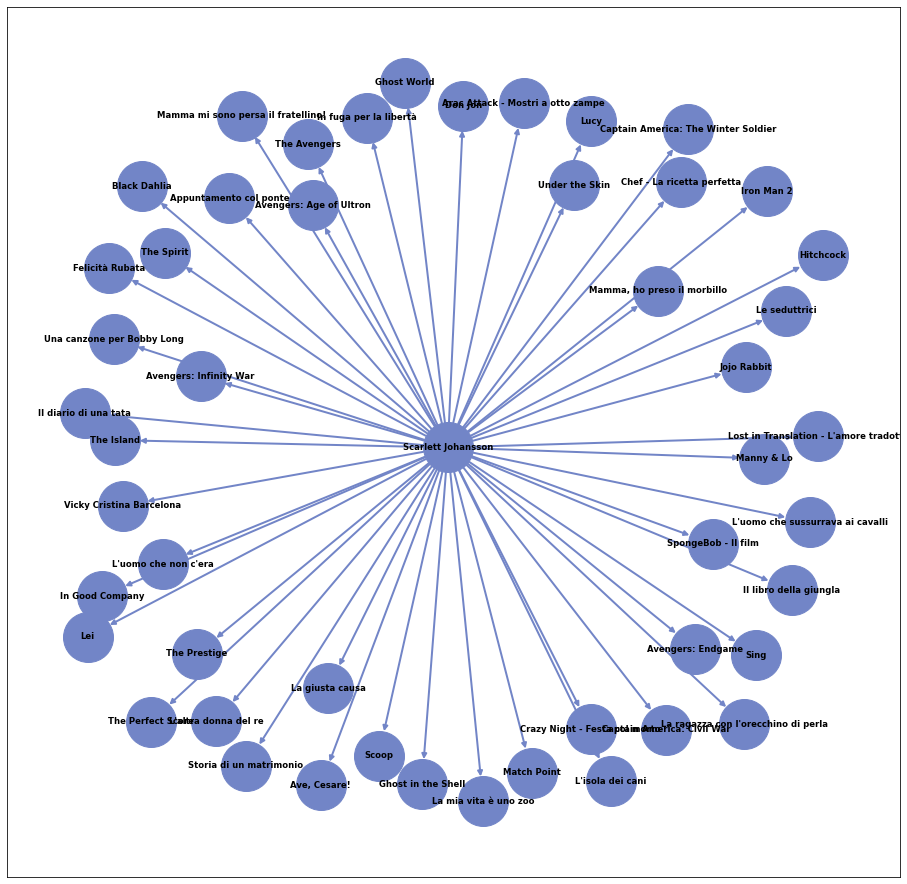

In [6]:
ego = nx.ego_graph(network, 'Scarlett Johansson')
pos = nx.spring_layout(ego, k=0.2, iterations=20)
plt.figure(figsize=(16,16))
opt = {
    'node_color': '#7285C7',
    'width': 2,
    'edge_color': '#7285C7',
    'font_size':8.5,
    'font_weight': 'bold'
}
nx.draw_networkx(ego, pos, node_size=2500, **opt)

### The Iron Man 2 digraph ego network [from: Scarllet Johansson]

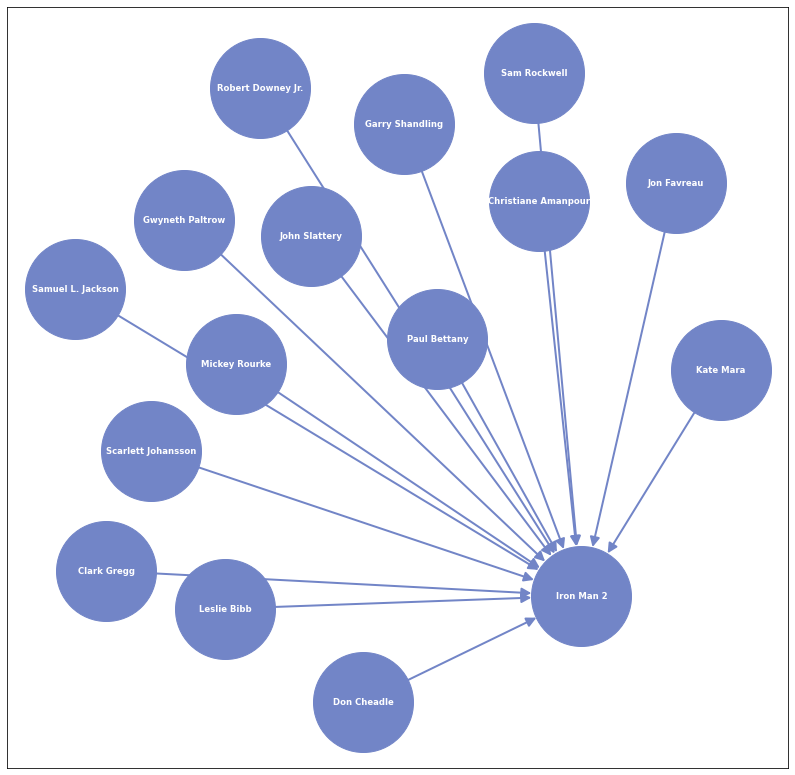

In [7]:
iron_man2 = nx.DiGraph()
iron_man2.add_edges_from(network.in_edges(['Iron Man 2']))
pos = nx.spring_layout(iron_man2, k=0.2, iterations=20)
plt.figure(figsize=(14,14))

options = {
    'node_size': 10000,
    'node_color': '#7285C7',
    'width': 2,
    'arrowsize': 20,
    'edge_color': '#7285C7',
    'font_size':8.5,
    'font_color': 'white',
    'font_weight': 'bold'
}

nx.draw_networkx(iron_man2, pos, **options)

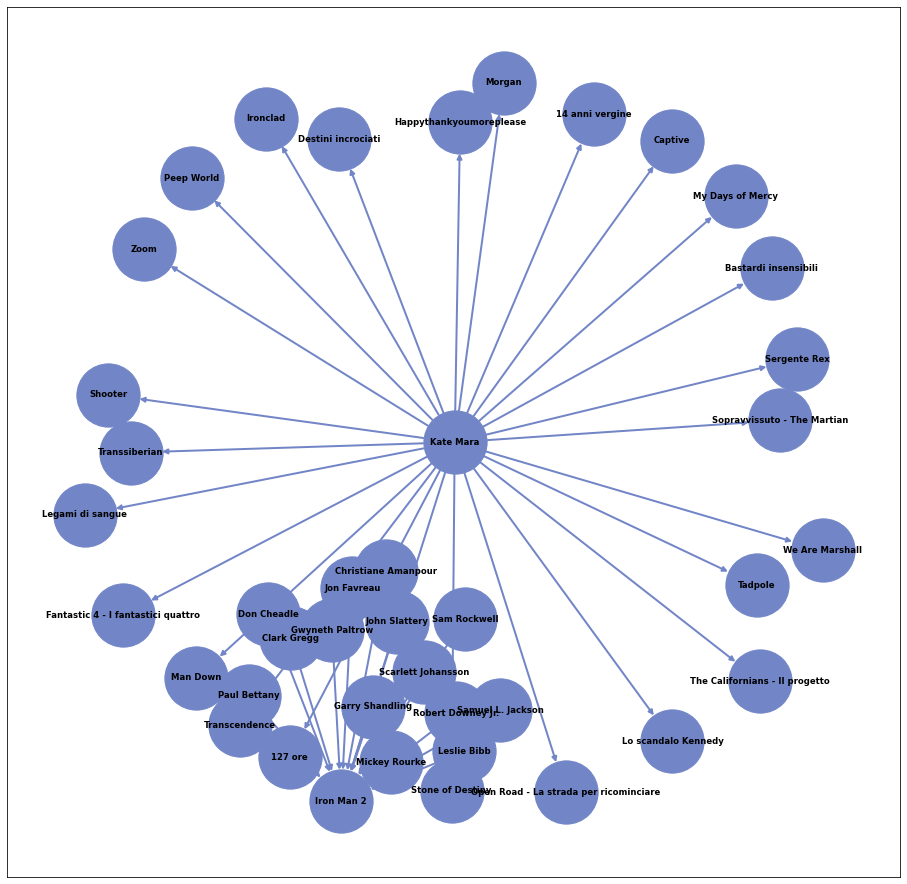

In [8]:
# full network of iron man 2 and its actors egonetworks 
# import copy 
# edges = copy.deepcopy(iron_man2.edges())
# for actor in edges:
#     node = actor[0]
#     iron_man2.add_edges_from(network.out_edges([node]))

"""
Select one actor of iron man 2 cast to expand the plot 
and show that the general network scales with multiple
ego network of its actors parts on movies 
"""


iron_man2.add_edges_from(network.edges(['Kate Mara']))

# Newplot with Kate Mara film networks
pos = nx.spring_layout(iron_man2, k=0.4, iterations=40)
plt.figure(figsize=(16,16))
nx.draw_networkx(iron_man2, pos, node_size=4000, **opt)

### Start clustering actors by country

In [9]:
data = []
for node in network.nodes():
    out_degree = network.out_degree(node)
    if out_degree > 0:
        row = {
            'actor': node,
            'out_degree': out_degree
        }
        data.append(row)
degree_df = pd.DataFrame(data, columns = ['actor', 'out_degree'])

In [10]:
""" Get only the actors with out_degree above average """

od_mean = round(degree_df['out_degree'].mean())
degree_df = degree_df.query('out_degree > @od_mean')
degree_df.head()

actor  out_degree
14    Frank Mills           8
16   Asta Nielsen           4
50   J.P. McGowan           7
51     Pola Negri          12
52  Emil Jannings          18

In [11]:
for i in degree_df.index:
    actor = degree_df['actor'][i]
    film = list(network.out_edges(actor)) 
    for job in film: 
        for country in network.nodes[job[1]]['country']:
            if country not in degree_df.columns:
                degree_df[country] = 0
            count = degree_df[country][i] + 1
            degree_df[country][i] = count

<ipython-input-11-2dd419672d96>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degree_df[country][i] = count


In [12]:
degree_df.head()

actor  out_degree  Australia  USA  UK  Germany  France  Denmark  \
14    Frank Mills           8          1    2   5        1       1        0   
16   Asta Nielsen           4          0    0   1        2       0        1   
50   J.P. McGowan           7          0    7   0        0       0        0   
51     Pola Negri          12          0    5   1        5       0        0   
52  Emil Jannings          18          0    4   1       13       0        0   

    Norway  Ukraine  ...  Faroe Islands  Guadeloupe  Reunion  Chad  Lesotho  \
14       0        0  ...              0           0        0     0        0   
16       1        0  ...              0           0        0     0        0   
50       0        0  ...              0           0        0     0        0   
51       0        1  ...              0           0        0     0        0   
52       0        0  ...              0           0        0     0        0   

    Malawi  North Vietnam  Cook Islands  Laos  Burma  
14       0              0             0     0      0  
16       0              0             0     0      0  
50       0              0             0     0      0  
51       0              0             0     0      0  
52       0              0             0     0      0  

[5 rows x 186 columns]

In [13]:
def plotbar_df(df, country):
    ct_df = df.query(f'{country} > 0')
    ct_df = ct_df[['actor', 'out_degree', country]]
    ct_df = ct_df.sort_values(by=[country], ascending=False)

    return ct_df

countries = ['USA', 'UK', 'France', 'Germany', 'India', 'Brazil']
df_plot = []
for country in countries:
    df_plot.append(plotbar_df(degree_df, country))

In [14]:
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=2,
                   subplot_titles=countries,
                    horizontal_spacing=0.16)

row, col = 1, 1
for i in range(len(countries)):
    my_df, loc = df_plot[i], countries[i]
    fig.add_trace(
        go.Bar(
            x=my_df[loc][:5],
            y=my_df['actor'][:5],
            orientation='h'
        ),
        row, col
    )
    col += 1
    if col > 2:
        row += 1
        col = 1

fig.update_layout(showlegend=False,
                  height=800, width=900,
                  title_text="Actors Films in Country",
                  font=dict(size=10))
fig.show()
# fig.write_image("images/actor_bycountry.png", engine="kaleido")

### Cossine similarity of an actor ego network

In [41]:
def handle_str(v1, v2):
    str_comp = list(set(v1 + v2))
    nv1 = [0] * len(str_comp)
    nv2 = [0] * len(str_comp)
    
    for v in v1: 
        if v in str_comp:
            i = str_comp.index(v)
            nv1[i] = 1
            
    for v in v2: 
        if v in str_comp:
            i = str_comp.index(v)
            nv2[i] = 1

    return nv1, nv2

def cos_sim(v1, v2):
    """cos_sim(v1,v2) defined as: 
    (v1 dot v2)/{||v1||*||v2||)"""
    
    v1v2 = np.dot(v1, v2)
    v1v1 = np.dot(v1, v1)
    v2v2 = np.dot(v2, v2)
    
    resp = v1v2 / (np.sqrt(v1v1 * v2v2))
    
    return resp

# v1 = ['Action', 'Comedy']
# v2 = ['Action', 'Adventure', 'Comedy']

# nv1, nv2 = handle_str(v1, v2)
# cos_sim(nv1, nv2)

In [55]:
brazil = df_plot[5]
# for i in df_plot[5].index[:5]:
#     print(brazil['actor'][i])

def matrix_of_sim(actor):
    actors_mvs = [x[1] for x in network.out_edges(actor)]
    n_mvs = len(actors_mvs)

    SIM_M = np.array([[0] * n_mvs] * n_mvs, dtype=float)

    for i in range(0, n_mvs):
        for j in range(0, n_mvs):
            k, l = actors_mvs[i], actors_mvs[j]

            v1 = network.nodes[k]['genre']
            v2 = network.nodes[l]['genre']

            nv1, nv2 = handle_str(v1, v2)
            SIM_M[i, j] = cos_sim(nv1, nv2)
    
    return SIM_M

In [161]:

select_actors = []
for c_df in df_plot:
    country = list(c_df.columns)[2]
    max_value = c_df[country] ==  c_df[country].max()
    name = c_df[max_value] # ator/atriz que mais fez filmes no país
    select_actors.append(name['actor'].values[0])

    
print(select_actors)


['Eric Roberts', 'Christopher Lee', 'Gérard Depardieu', 'Moritz Bleibtreu', 'Brahmanandam', 'Milhem Cortaz']


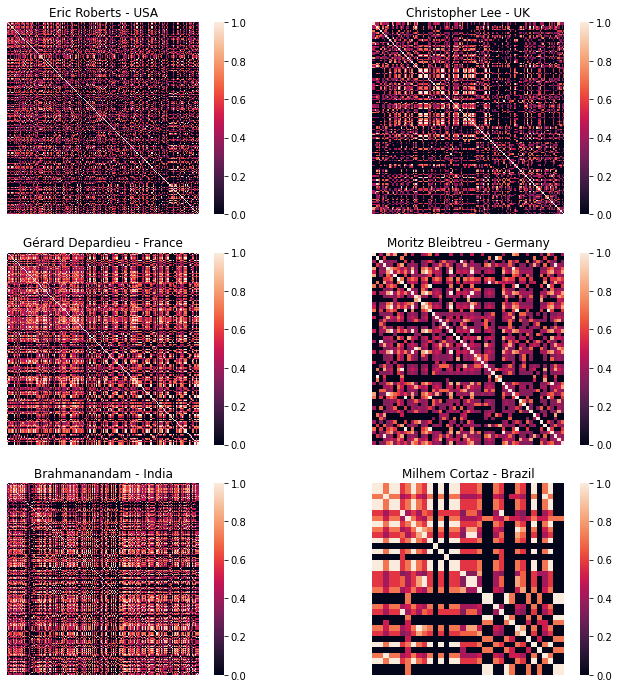

In [213]:
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(12,12))
axes = [axs[0, 0], axs[0, 1],
        axs[1, 0], axs[1, 1],
        axs[2, 0], axs[2, 1]]

for i, actor in enumerate(select_actors):
    M = matrix_of_sim(actor)

    sns.heatmap(M, square=True,
                xticklabels=False,
                yticklabels=False,
                ax=axes[i])
    axes[i].set_title(f'{actor} - {countries[i]}')
    
# eric_r = matrix_of_sim('Eric Roberts')
# print(np.mean(eric_r))
# renato_a = matrix_of_sim('Renato Aragão')
# print(np.mean(renato_a))
# plt.savefig('images/actors_matrix_of_sim.png')

### Recommend based on [categoria? filme c melhor rating do ator?]

### Cossine similarity between countries actors 

### Merge with ratings df

### Shortest path of an actor to another by transforming the digraph in graph